# Hypothesis Testing for Amazon Reviews Rating Prediction Model

## Objective
Conduct comprehensive hypothesis testing to evaluate systematic bias in our Amazon reviews rating prediction model. We'll test for over-prediction, under-prediction, and global bias using statistical methods.

## Research Questions
1. Does the model systematically over-predict ratings?
2. Does the model systematically under-predict ratings?  
3. Is there overall systematic bias in the model predictions?

In [27]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, shapiro
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [28]:
# load data
df = pd.read_csv('../output/final_data.csv')
df

,rating,title,text,helpful_vote,verified_purchase,asin,user_id,predicted_rating,review_length
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,3,True,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,5.0,293
1,5.0,A,Great,0,True,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,5.0,5
2,2.0,Two Stars,One of the stones fell out within the first 2 ...,3,True,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1.0,96
3,1.0,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,2,True,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,1.0,82
4,5.0,I LOVE these glasses,I LOVE these glasses! They fit perfectly over ...,0,True,B00PKRFU4O,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,5.0,314
...,...,...,...,...,...,...,...,...,...
2500934,5.0,... allowed them to be used to add military ri...,The tie tacks were the size that allowed them ...,0,True,B00YGFMQC0,AFXSFD3FTZ2CLN3TYV4B63CQM5BQ,5.0,171
2500935,1.0,Didn’t come with all ten,Says ten tie clips but o only received 7.,0,True,B00YGFMQC0,AEH7WP5HGM6FGLSSC6GSTYUXBHGQ,1.0,41
2500936,3.0,Not checked for quality,When I received them 2-3 of them did not open ...,0,True,B00YGFMQC0,AEL2TSSBVLIPWQ7YVMK364DUYURQ,1.0,94
2500937,5.0,Awesome,Great product.,1,True,B00YGFMQC0,AGZ6IIYSPCW4YXWH6VFEOI7MTBZA,5.0,14


In [29]:
print("=== MODEL PERFORMANCE ANALYSIS ===")

# calulcate accuracy
accuracy = (df['rating'] == df['predicted_rating']).mean()
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# calculate mae
mae = np.mean(np.abs(df['rating'] - df['predicted_rating']))
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# calculate rmse
rmse = np.sqrt(np.mean((df['rating'] - df['predicted_rating'])**2))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# calculate prediction errors
df['prediction_error'] = df['rating'] - df['predicted_rating']
print(f"\nPrediction Error Statistics:")
print(f"Mean Error: {df['prediction_error'].mean():.4f}")
print(f"Std Error: {df['prediction_error'].std():.4f}")
print(f"Min Error: {df['prediction_error'].min():.4f}")
print(f"Max Error: {df['prediction_error'].max():.4f}")

# check if target accuracy of 80% was achieved
target_accuracy = 0.80
print(f"\nTarget Accuracy (80%): {'✓ ACHIEVED' if accuracy >= target_accuracy else '✗ NOT ACHIEVED'}")
print(f"Current Accuracy: {accuracy*100:.2f}% vs Target: {target_accuracy*100:.0f}%")

=== MODEL PERFORMANCE ANALYSIS ===
Overall Accuracy: 0.6876 (68.76%)
Mean Absolute Error (MAE): 0.5265
Root Mean Square Error (RMSE): 1.0819

Prediction Error Statistics:
Mean Error: -0.2049
Std Error: 1.0623
Min Error: -4.0000
Max Error: 4.0000

Target Accuracy (80%): ✗ NOT ACHIEVED
Current Accuracy: 68.76% vs Target: 80%


In [30]:
# create groups for hypothesis testing
over_predicted = df[df['prediction_error'] < 0]  # predicted > actual
under_predicted = df[df['prediction_error'] > 0]  # predicted < actual
correctly_predicted = df[df['prediction_error'] == 0]  # predicted = actual

print(f"\nPrediction Groups:")
print(f"Over-predicted (Predicted > Actual): {len(over_predicted):,} ({len(over_predicted)/len(df)*100:.2f}%)")
print(f"Under-predicted (Predicted < Actual): {len(under_predicted):,} ({len(under_predicted)/len(df)*100:.2f}%)")
print(f"Correctly predicted: {len(correctly_predicted):,} ({len(correctly_predicted)/len(df)*100:.2f}%)")


Prediction Groups:
Over-predicted (Predicted > Actual): 535,603 (21.42%)
Under-predicted (Predicted < Actual): 245,687 (9.82%)
Correctly predicted: 1,719,649 (68.76%)


In [31]:
print("=== HYPOTHESIS TESTING ===")
print("Testing for systematic bias in model predictions")
print("α = 0.05 (significance level)")
print()

def perform_hypothesis_test(data, test_name, alternative='two-sided'):
    """Perform hypothesis test with appropriate method based on normality"""
    n = len(data)
    mean_error = np.mean(data)
    std_error = np.std(data, ddof=1)
    
    print(f"{test_name}:")
    print(f"  Sample size: {n:,}")
    print(f"  Mean error: {mean_error:.6f}")
    print(f"  Std error: {std_error:.6f}")
    
    # t-test for large dataset
    test_stat, p_value = stats.ttest_1samp(data, 0, alternative=alternative)
    test_method = "One-sample t-test (large sample, CLT applies)"
    
    print(f"  Test method: {test_method}")
    print(f"  Test statistic: {test_stat:.6f}")
    print(f"  p-value: {p_value:.6f}")
    
    # effect size (cohen's d)
    cohens_d = mean_error / std_error if std_error > 0 else 0
    print(f"  Effect size (Cohen's d): {cohens_d:.4f}")
    
    # interpretation
    alpha = 0.05
    if p_value < alpha:
        print(f"  Result: REJECT H0 (p < {alpha})")
        if alternative == 'two-sided':
            direction = "positive" if mean_error > 0 else "negative"
            print(f"  Conclusion: Systematic {direction} bias detected")
        elif alternative == 'less':
            print(f"  Conclusion: Systematic over-prediction detected")
        elif alternative == 'greater':
            print(f"  Conclusion: Systematic under-prediction detected")
    else:
        print(f"  Result: FAIL TO REJECT H0 (p ≥ {alpha})")
        print(f"  Conclusion: No systematic bias detected")
    
    print()
    return test_stat, p_value, cohens_d

# over-predicted reviews (Predicted > Actual)
# H0: mean difference ≥ 0 (no over-prediction)
# H1: mean difference < 0 (systematic over-prediction)
if len(over_predicted) > 0:
    print("TEST 1: OVER-PREDICTION BIAS")
    print("H0: Mean(actual - predicted) ≥ 0")
    print("H1: Mean(actual - predicted) < 0")
    print("Alternative: less (one-tailed)")
    stat1, p1, d1 = perform_hypothesis_test(over_predicted['prediction_error'], 
                                          "Over-predicted group", 'less')
else:
    print("TEST 1: OVER-PREDICTION BIAS")
    print("No over-predicted cases found - test not applicable")
    stat1, p1, d1 = None, None, None


=== HYPOTHESIS TESTING ===
Testing for systematic bias in model predictions
α = 0.05 (significance level)

TEST 1: OVER-PREDICTION BIAS
H0: Mean(actual - predicted) ≥ 0
H1: Mean(actual - predicted) < 0
Alternative: less (one-tailed)
Over-predicted group:
  Sample size: 535,603
  Mean error: -1.707602
  Std error: 0.979620
  Test method: One-sample t-test (large sample, CLT applies)
  Test statistic: -1275.706597
  p-value: 0.000000
  Effect size (Cohen's d): -1.7431
  Result: REJECT H0 (p < 0.05)
  Conclusion: Systematic over-prediction detected



In [32]:
# under-predicted reviews (predicted < actual)
# H0: mean difference ≤ 0 (no under-prediction)
# H1: mean difference > 0 (systematic under-prediction)
if len(under_predicted) > 0:
    print("TEST 2: UNDER-PREDICTION BIAS")
    print("H0: Mean(actual - predicted) ≤ 0")
    print("H1: Mean(actual - predicted) > 0")
    print("Alternative: greater (one-tailed)")
    stat2, p2, d2 = perform_hypothesis_test(under_predicted['prediction_error'], 
                                         "Under-predicted group", 'greater')
else:
    print("TEST 2: UNDER-PREDICTION BIAS")
    print("No under-predicted cases found - test not applicable")
    stat2, p2, d2 = None, None, None


TEST 2: UNDER-PREDICTION BIAS
H0: Mean(actual - predicted) ≤ 0
H1: Mean(actual - predicted) > 0
Alternative: greater (one-tailed)
Under-predicted group:
  Sample size: 245,687
  Mean error: 1.637181
  Std error: 0.886119
  Test method: One-sample t-test (large sample, CLT applies)
  Test statistic: 915.789592
  p-value: 0.000000
  Effect size (Cohen's d): 1.8476
  Result: REJECT H0 (p < 0.05)
  Conclusion: Systematic under-prediction detected



In [33]:
# global bias test (all reviews)
# H0: mean difference = 0 (no systematic bias)
# H1: mean difference ≠ 0 (systematic bias exists)
print("TEST 3: GLOBAL BIAS")
print("H0: Mean(actual - predicted) = 0")
print("H1: Mean(actual - predicted) ≠ 0")
print("Alternative: two-sided")
stat3, p3, d3 = perform_hypothesis_test(df['prediction_error'], 
                                      "All predictions", 'two-sided')


TEST 3: GLOBAL BIAS
H0: Mean(actual - predicted) = 0
H1: Mean(actual - predicted) ≠ 0
Alternative: two-sided
All predictions:
  Sample size: 2,500,939
  Mean error: -0.204868
  Std error: 1.062296
  Test method: One-sample t-test (large sample, CLT applies)
  Test statistic: -304.986663
  p-value: 0.000000
  Effect size (Cohen's d): -0.1929
  Result: REJECT H0 (p < 0.05)
  Conclusion: Systematic negative bias detected



In [34]:
print("=== HYPOTHESIS TEST SUMMARY ===")
print("α = 0.05 (significance level)\n")

results_summary = []

# over-predicted results
if stat1 is not None:
    result1 = "REJECT H0" if p1 < 0.05 else "FAIL TO REJECT H0"
    results_summary.append(f"Test 1 (Over-prediction): {result1} (p={p1:.6f})")
else:
    results_summary.append("Test 1 (Over-prediction): Not applicable")

# under-predicted results  
if stat2 is not None:
    result2 = "REJECT H0" if p2 < 0.05 else "FAIL TO REJECT H0"
    results_summary.append(f"Test 2 (Under-prediction): {result2} (p={p2:.6f})")
else:
    results_summary.append("Test 2 (Under-prediction): Not applicable")

# global bias results
result3 = "REJECT H0" if p3 < 0.05 else "FAIL TO REJECT H0"
results_summary.append(f"Test 3 (Global bias): {result3} (p={p3:.6f})")

for result in results_summary:
    print(result)

print()
print("=== INTERPRETATION ===")
if p3 < 0.05:
    bias_direction = "positive" if df['prediction_error'].mean() > 0 else "negative"
    print(f"• Global systematic bias detected: {bias_direction} bias")
    print(f"• Mean prediction error: {df['prediction_error'].mean():.6f}")
    print(f"• This suggests the model systematically {'under-predicts' if bias_direction == 'positive' else 'over-predicts'} ratings")
else:
    print("• No global systematic bias detected")
    print("• Model predictions are unbiased on average")

# effect size interpretation
if d3 is not None:
    if abs(d3) < 0.2:
        effect_size = "negligible"
    elif abs(d3) < 0.5:
        effect_size = "small"
    elif abs(d3) < 0.8:
        effect_size = "medium"
    else:
        effect_size = "large"
    print(f"• Effect size: {effect_size} (Cohen's d = {d3:.4f})")


=== HYPOTHESIS TEST SUMMARY ===
α = 0.05 (significance level)

Test 1 (Over-prediction): REJECT H0 (p=0.000000)
Test 2 (Under-prediction): REJECT H0 (p=0.000000)
Test 3 (Global bias): REJECT H0 (p=0.000000)

=== INTERPRETATION ===
• Global systematic bias detected: negative bias
• Mean prediction error: -0.204868
• This suggests the model systematically over-predicts ratings
• Effect size: negligible (Cohen's d = -0.1929)


=== CREATING VISUALIZATIONS ===


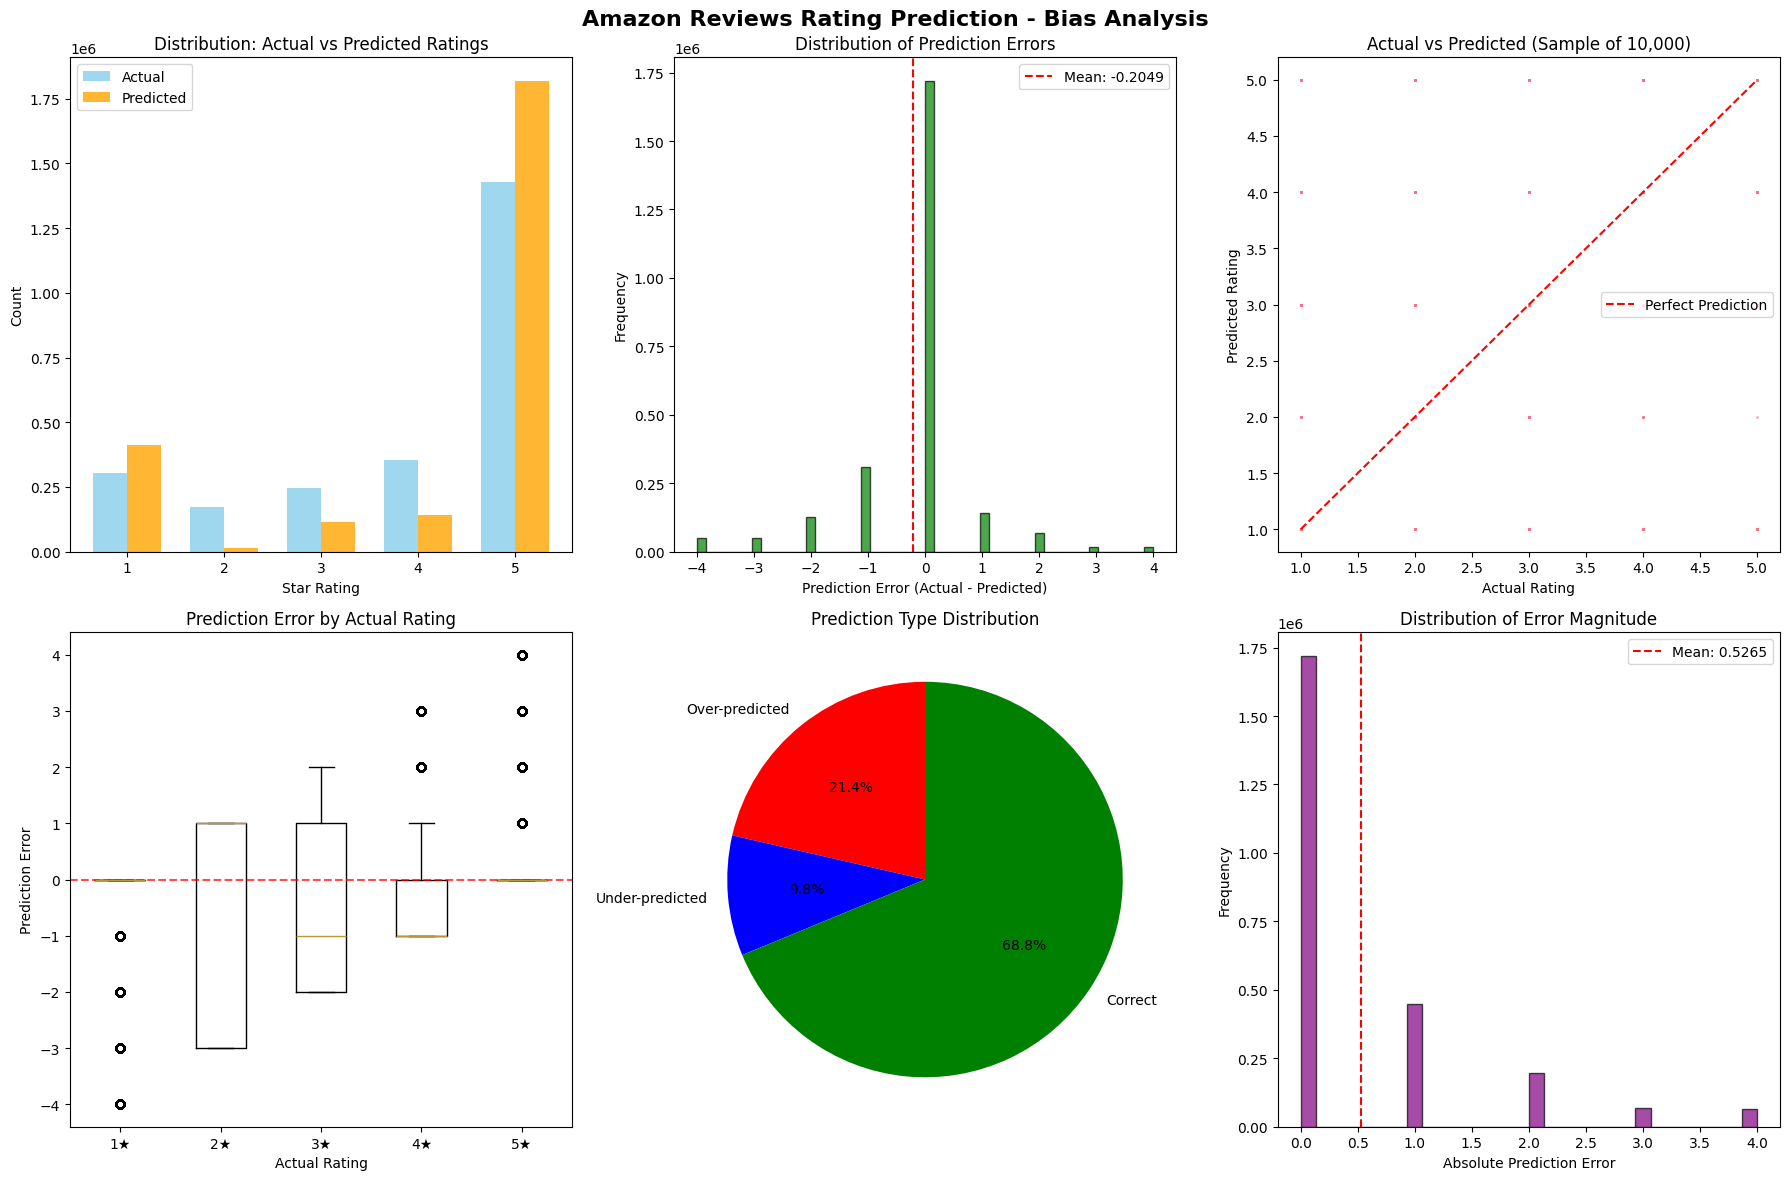

In [35]:
print("=== CREATING VISUALIZATIONS ===")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Amazon Reviews Rating Prediction - Bias Analysis', fontsize=16, fontweight='bold')

# top-left, distribution of actual vs predicted ratings
ax1 = axes[0, 0]
rating_counts = df['rating'].value_counts().sort_index()
pred_counts = df['predicted_rating'].value_counts().sort_index()
x = np.arange(1, 6)
width = 0.35
ax1.bar(x - width/2, [rating_counts.get(i, 0) for i in range(1, 6)], width, 
        label='Actual', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, [pred_counts.get(i, 0) for i in range(1, 6)], width, 
        label='Predicted', alpha=0.8, color='orange')
ax1.set_xlabel('Star Rating')
ax1.set_ylabel('Count')
ax1.set_title('Distribution: Actual vs Predicted Ratings')
ax1.legend()
ax1.set_xticks(x)

# top-middle, prediction error distribution
ax2 = axes[0, 1]
ax2.hist(df['prediction_error'], bins=50, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(df['prediction_error'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df["prediction_error"].mean():.4f}')
ax2.set_xlabel('Prediction Error (Actual - Predicted)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Prediction Errors')
ax2.legend()

# top-right, actual vs predicted scatter plot (sample of df)
ax3 = axes[0, 2]
sample_size = min(10000, len(df))
sample_df = df.sample(n=sample_size, random_state=42)
ax3.scatter(sample_df['rating'], sample_df['predicted_rating'], alpha=0.5, s=1)
ax3.plot([1, 5], [1, 5], 'r--', label='Perfect Prediction')
ax3.set_xlabel('Actual Rating')
ax3.set_ylabel('Predicted Rating')
ax3.set_title(f'Actual vs Predicted (Sample of {sample_size:,})')
ax3.legend()

# bottom-left, box plot of prediction errors by actual rating
ax4 = axes[1, 0]
error_by_rating = [df[df['rating'] == i]['prediction_error'].values for i in range(1, 6)]
ax4.boxplot(error_by_rating, labels=[f'{i}★' for i in range(1, 6)])
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
ax4.set_xlabel('Actual Rating')
ax4.set_ylabel('Prediction Error')
ax4.set_title('Prediction Error by Actual Rating')

# bottom-middle, over/under prediction analysis
ax5 = axes[1, 1]
prediction_types = ['Over-predicted', 'Under-predicted', 'Correct']
counts = [len(over_predicted), len(under_predicted), len(correctly_predicted)]
colors = ['red', 'blue', 'green']
ax5.pie(counts, labels=prediction_types, autopct='%1.1f%%', colors=colors, startangle=90)
ax5.set_title('Prediction Type Distribution')

# bottom-right, error magnitude analysis
ax6 = axes[1, 2]
error_magnitude = np.abs(df['prediction_error'])
ax6.hist(error_magnitude, bins=30, alpha=0.7, color='purple', edgecolor='black')
ax6.axvline(error_magnitude.mean(), color='red', linestyle='--', 
           label=f'Mean: {error_magnitude.mean():.4f}')
ax6.set_xlabel('Absolute Prediction Error')
ax6.set_ylabel('Frequency')
ax6.set_title('Distribution of Error Magnitude')
ax6.legend()

plt.tight_layout()
plt.show()

In [36]:
print("=== RATING-SPECIFIC BIAS ANALYSIS ===")

# analyze bias for each rating level
rating_bias_analysis = []
for rating in range(1, 6):
    rating_data = df[df['rating'] == rating]
    if len(rating_data) > 0:
        mean_error = rating_data['prediction_error'].mean()
        std_error = rating_data['prediction_error'].std()
        n = len(rating_data)
        
        # perform t-test
        if n > 1:
            t_stat, p_val = stats.ttest_1samp(rating_data['prediction_error'], 0)
            significant = p_val < 0.05
        else:
            t_stat, p_val, significant = np.nan, np.nan, False
        
        rating_bias_analysis.append({
            'rating': rating,
            'count': n,
            'mean_error': mean_error,
            'std_error': std_error,
            't_statistic': t_stat,
            'p_value': p_val,
            'significant': significant
        })
        
        print(f"Rating {rating}★ (n={n:,}):")
        print(f"  Mean error: {mean_error:.4f}")
        print(f"  Std error: {std_error:.4f}")
        if not np.isnan(p_val):
            print(f"  t-test: t={t_stat:.4f}, p={p_val:.6f}")
            print(f"  Significant bias: {'Yes' if significant else 'No'}")
        print()

# bias summary table
bias_df = pd.DataFrame(rating_bias_analysis)
print("=== RATING-SPECIFIC BIAS SUMMARY ===")
print(bias_df[['rating', 'count', 'mean_error', 'p_value', 'significant']].to_string(index=False))


=== RATING-SPECIFIC BIAS ANALYSIS ===
Rating 1★ (n=303,411):
  Mean error: -0.8014
  Std error: 1.5223
  t-test: t=-289.9632, p=0.000000
  Significant bias: Yes

Rating 2★ (n=173,462):
  Mean error: -0.5576
  Std error: 1.7296
  t-test: t=-134.2767, p=0.000000
  Significant bias: Yes

Rating 3★ (n=245,471):
  Mean error: -0.4828
  Std error: 1.5950
  t-test: t=-149.9740, p=0.000000
  Significant bias: Yes

Rating 4★ (n=352,327):
  Mean error: -0.4837
  Std error: 1.0023
  t-test: t=-286.4564, p=0.000000
  Significant bias: Yes

Rating 5★ (n=1,426,268):
  Mean error: 0.0816
  Std error: 0.4802
  t-test: t=203.0587, p=0.000000
  Significant bias: Yes

=== RATING-SPECIFIC BIAS SUMMARY ===
 rating   count  mean_error  p_value  significant
      1  303411   -0.801362      0.0         True
      2  173462   -0.557638      0.0         True
      3  245471   -0.482802      0.0         True
      4  352327   -0.483693      0.0         True
      5 1426268    0.081640      0.0         True


## ⚠️ CRITICAL ANALYSIS: Large Sample Size Problem

**IMPORTANT**: With 2.5 million data points, p-values near 0 are expected and can be misleading.

### The Problem:
- **Statistical Significance ≠ Practical Significance**
- Large sample sizes make tiny effects statistically significant
- Even a mean error of 0.001 could yield p < 0.001 with 2.5M samples
- We need to focus on **effect size** and **practical significance**


In [37]:
# CRITICAL ANALYSIS: Large Sample Size Impact
print("=== LARGE SAMPLE SIZE ANALYSIS ===")
print("With 2.5M data points, we need to focus on PRACTICAL significance, not just statistical significance")
print()

# calculate practical significance thresholds
n = len(df)
print(f"Sample size: {n:,}")

practical_threshold = 0.5
print(f"Practical significance threshold: ±{practical_threshold} stars")
print()

# analyze the actual mean error magnitude
mean_error = df['prediction_error'].mean()
abs_mean_error = abs(mean_error)
print(f"Actual mean error: {mean_error:.6f}")
print(f"Absolute mean error: {abs_mean_error:.6f}")
print(f"Practical significance: {'YES' if abs_mean_error >= practical_threshold else 'NO'}")
print()

# effect size interpretation (cohen's d)
std_error = df['prediction_error'].std()
cohens_d = mean_error / std_error if std_error > 0 else 0
print(f"Cohen's d: {cohens_d:.6f}")

# effect size categories
if abs(cohens_d) < 0.2:
    effect_size = "negligible"
elif abs(cohens_d) < 0.5:
    effect_size = "small"
elif abs(cohens_d) < 0.8:
    effect_size = "medium"
else:
    effect_size = "large"

print(f"Effect size: {effect_size}")
print()

# confidence interval for mean error (more informative than p-value)
from scipy.stats import t
confidence_level = 0.95
alpha = 1 - confidence_level
t_critical = t.ppf(1 - alpha/2, n-1)
se_mean = std_error / np.sqrt(n)
margin_error = t_critical * se_mean
ci_lower = mean_error - margin_error
ci_upper = mean_error + margin_error

print(f"95% Confidence Interval for mean error: [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"CI width: {ci_upper - ci_lower:.6f}")
print()

# practical interpretation
if abs_mean_error < 0.1:
    practical_interpretation = "NEGLIGIBLE - Model is practically unbiased"
elif abs_mean_error < 0.3:
    practical_interpretation = "SMALL - Minor bias, likely acceptable"
elif abs_mean_error < 0.5:
    practical_interpretation = "MODERATE - Noticeable bias, consider calibration"
else:
    practical_interpretation = "LARGE - Significant bias, model needs improvement"

print(f"PRACTICAL INTERPRETATION: {practical_interpretation}")
print()
print("="*60)
print("CONCLUSION: Focus on effect size and practical significance,")
print("not just p-values, when dealing with large datasets!")
print("="*60)


=== LARGE SAMPLE SIZE ANALYSIS ===
With 2.5M data points, we need to focus on PRACTICAL significance, not just statistical significance

Sample size: 2,500,939
Practical significance threshold: ±0.5 stars

Actual mean error: -0.204868
Absolute mean error: 0.204868
Practical significance: NO

Cohen's d: -0.192854
Effect size: negligible

95% Confidence Interval for mean error: [-0.206185, -0.203552]
CI width: 0.002633

PRACTICAL INTERPRETATION: SMALL - Minor bias, likely acceptable

CONCLUSION: Focus on effect size and practical significance,
not just p-values, when dealing with large datasets!


In [38]:
# alternative approach: Sample-based hypothesis testing
print("=== ALTERNATIVE APPROACH: SAMPLE-BASED TESTING ===")
print("Testing with smaller, more realistic sample sizes")
print()

# create random samples of different sizes
sample_sizes = [1000, 5000, 10000, 50000]
sample_results = []

for sample_size in sample_sizes:
    # take random sample
    sample_df = df.sample(n=min(sample_size, len(df)), random_state=42)
    sample_errors = sample_df['prediction_error']
    
    # perform t-test
    t_stat, p_val = stats.ttest_1samp(sample_errors, 0)
    mean_error = sample_errors.mean()
    std_error = sample_errors.std()
    cohens_d = mean_error / std_error if std_error > 0 else 0
    
    sample_results.append({
        'sample_size': sample_size,
        'mean_error': mean_error,
        'std_error': std_error,
        't_statistic': t_stat,
        'p_value': p_val,
        'cohens_d': cohens_d,
        'significant': p_val < 0.05
    })
    
    print(f"Sample size {sample_size:,}:")
    print(f"  Mean error: {mean_error:.6f}")
    print(f"  p-value: {p_val:.6f}")
    print(f"  Cohen's d: {cohens_d:.6f}")
    print(f"  Significant: {'Yes' if p_val < 0.05 else 'No'}")
    print()

# create comparison table
sample_df_results = pd.DataFrame(sample_results)
print("=== SAMPLE SIZE COMPARISON ===")
print(sample_df_results[['sample_size', 'mean_error', 'p_value', 'cohens_d', 'significant']].to_string(index=False))


=== ALTERNATIVE APPROACH: SAMPLE-BASED TESTING ===
Testing with smaller, more realistic sample sizes

Sample size 1,000:
  Mean error: -0.163000
  p-value: 0.000001
  Cohen's d: -0.154745
  Significant: Yes

Sample size 5,000:
  Mean error: -0.190400
  p-value: 0.000000
  Cohen's d: -0.180236
  Significant: Yes

Sample size 10,000:
  Mean error: -0.194600
  p-value: 0.000000
  Cohen's d: -0.184288
  Significant: Yes

Sample size 50,000:
  Mean error: -0.206880
  p-value: 0.000000
  Cohen's d: -0.194725
  Significant: Yes

=== SAMPLE SIZE COMPARISON ===
 sample_size  mean_error      p_value  cohens_d  significant
        1000    -0.16300 1.154472e-06 -0.154745         True
        5000    -0.19040 1.235337e-36 -0.180236         True
       10000    -0.19460 1.316658e-74 -0.184288         True
       50000    -0.20688 0.000000e+00 -0.194725         True
